# Initialization

In [1]:
# %load init.ipy
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime, warnings, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
# from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
# from kalepy.plot import plot_control

def _save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot._save_fig(fig, fname, **kwargs)
    
save_fig = _save_fig

In [2]:
def save_fig(fig, fname, **kwargs):
    kwargs.setdefault('subdir', 'plotting')
    return _save_fig(fig, fname, **kwargs)

In [3]:
import kalepy as kale

reload(kale.kde)
reload(kale.kernels)
reload(kale.utils)
reload(kale.plot)
reload(kale)

<module 'kalepy' from '/Users/lzkelley/Programs/kalepy/kalepy/__init__.py'>

# 1D Distributions

## 1D - Data Only

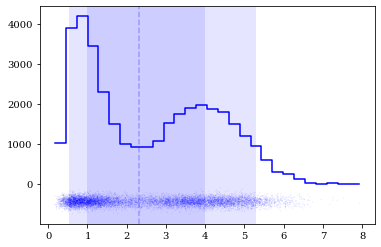

In [4]:
# Generate randomish data
data, _ = kale.utils._random_data_1d_01()
color = 'b'
# Plot 1D Histogram
kale.plot.hist1d(data, color=color, density=True)
# Add "carpet" plot (1D scatter) 
kale.plot.carpet(data, color=color)
# Add median and confidence intervals
kale.plot.contour1d(data, quantiles=[0.5, 0.9], color=color)

Overplot two distributions using the same bin-sizes

(<matplotlib.collections.PathCollection at 0x7ff47986d400>,
 array([-0.03826692, -0.00724528]))

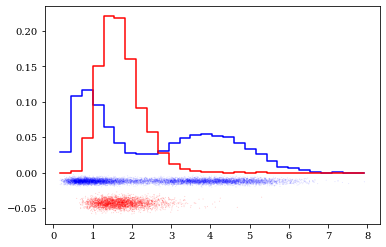

In [5]:
# Generate randomish data
data1, _ = kale.utils._random_data_1d_01()
data2 = np.random.lognormal(0.5, 0.3, size=data1.size//3)

kw = dict(
    probability=True,    # normalize so that the sum of all bins is unity
)

# Plot first dataset in blue and store bin-edges
_, edges, _ = kale.plot.hist1d(data1, color='b', **kw)
# Add carpet plot
kale.plot.carpet(data1, color='b')

# Plot second dataset in red using previous bin-edges
kale.plot.hist1d(data2, edges=edges, color='r', **kw)
# Add carpet plot, and shift it downwards
kale.plot.carpet(data2, color='r', shift=-0.02)


## 1D - KDE 

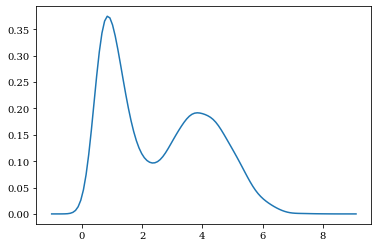

In [6]:
# Generate randomish data
data, _ = kale.utils._random_data_1d_01()
# Calculate the KDE density distribution
edges, pdf = kale.density(data, probability=True)
# Simple line plot
plt.plot(edges, pdf);

Using the kalepy `dist1d` plotting function:

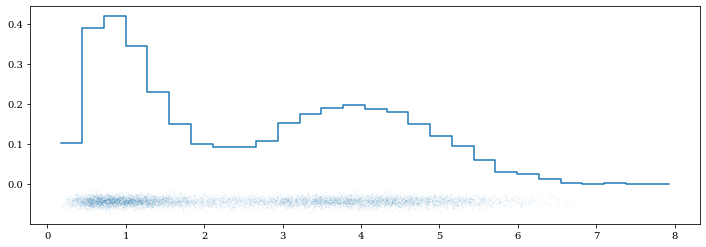

In [7]:
# Generate randomish data
data, _ = kale.utils._random_data_1d_01()
# Plot the KDE and the data (using histogram and carpet plots)
fig, ax = plt.subplots(figsize=[12, 4])
kale.plot.dist1d(data, ax=ax, hist=True, carpet=True, contour=False)

# 2D Distributions

2D - Data Only

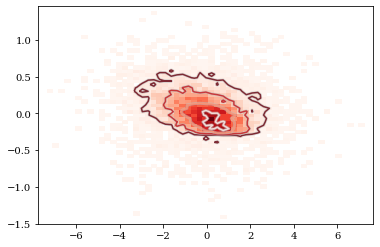

In [8]:
# Generate randomish data
data = kale.utils._random_data_2d_01(num=1e4)

# Standard 2D Histogram, mask empty bins
kale.plot.hist2d(data, cmap='Reds', mask_below=True);
# Contours
kale.plot.contour2d(data, cmap='Reds_r');

Vary contour smoothing and upsampling

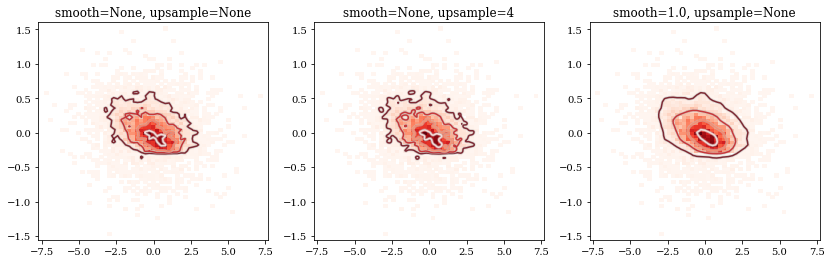

In [9]:
# Generate randomish data
data = kale.utils._random_data_2d_01(num=1e4)

fig, axes = plt.subplots(figsize=[14, 4], ncols=3)
upsample = [None, 4, None]
smooth = [None, None, 1.0]

for ax, up, sm in zip(axes, upsample, smooth):
    title = f"smooth={sm}, upsample={up}"
    ax.set_title(title)
    # Standard 2D Histogram, mask empty bins
    kale.plot.hist2d(data, ax=ax, cmap='Reds', mask_below=True);
    # Contours
    kale.plot.contour2d(data, ax=ax, cmap='Reds_r', upsample=up, smooth=sm);
    
plt.show()

## 2D - with KDE

just a KDE using matplotlib contours

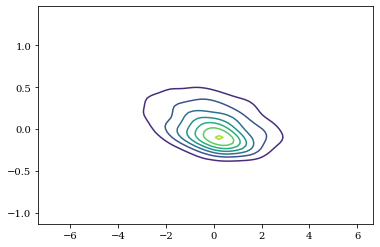

In [10]:
# Generate random-ish data
data = kale.utils._random_data_2d_01(num=1e3)

# Calculate PDF from KDE
points, pdf = kale.density(data)

# Simple contour plot
plt.contour(*points, pdf.T);

Using the kalepy `dist2d` plotting function

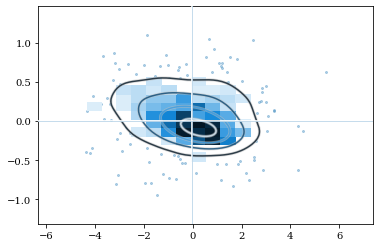

In [11]:
# Generate random-ish data
data = kale.utils._random_data_2d_01(num=1e3)
# Plot data as scatter and histogram, and KDE as contours
kale.plot.dist2d(data);

Compare KDE contours with data contours

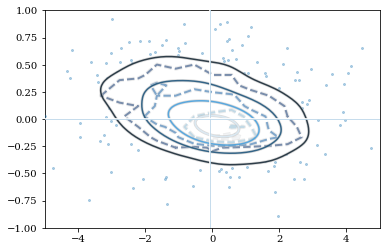

In [12]:
# Generate random-ish data
data = kale.utils._random_data_2d_01(num=1e3)
# Plot data as scatter and histogram, and KDE as contours
kale.plot.dist2d(data, hist=False);
# Compare against contours from data
kale.plot.contour2d(data, cmap='Blues_r', ls='--', lw=2.0, alpha=0.5);
# Zoom in a little
plt.gca().set(xlim=[-5, 5], ylim=[-1, 1]);

Compare two different distributions

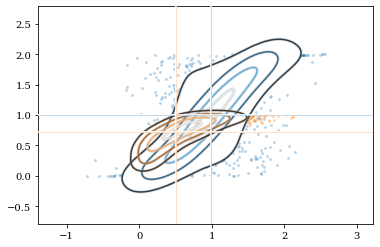

In [13]:
# Generate random-ish data
data1 = kale.utils._random_data_2d_02(num=2e3)
data2 = kale.utils._random_data_2d_03(num=2e3)

# Plot data as scatter and KDE as contours
# # Data 1
# kale.plot.dist2d(data1, hist=False, cmap='Reds');
# # Data 2
# kale.plot.dist2d(data2, hist=False, cmap='Blues');

# Data 1
kale.plot.dist2d(data1, hist=False);
# Data 2
kale.plot.dist2d(data2, hist=False);


# Multidimensional Corner / Pair Plots

## Data Only

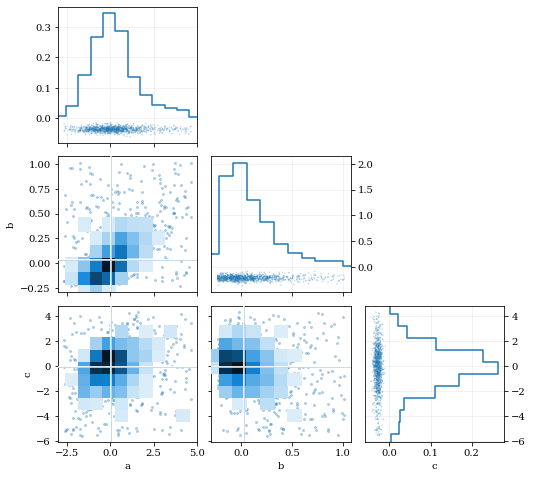

In [14]:
# Generate randomish data
data = kale.utils._random_data_3d_01()
# Initialize a corner plot with the given data, set axes labels
corner = kale.plot.Corner(data, labels=['a', 'b', 'c'], figsize=8)
# Plot with default settings
corner.plot_data()

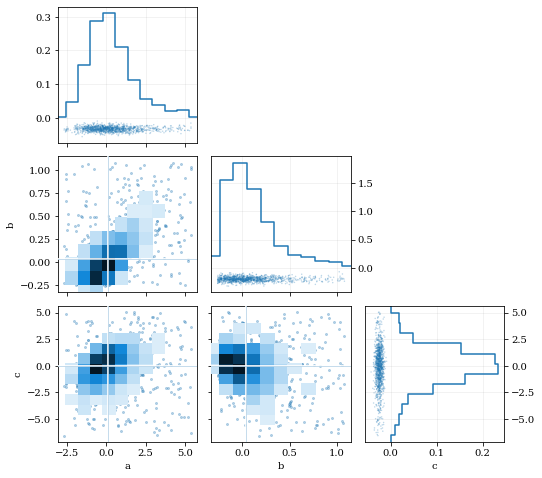

In [15]:
# Generate randomish data
data = kale.utils._random_data_3d_01()
# Initialize a corner plot with the given data, set axes labels
corner = kale.plot.Corner(data, labels=['a', 'b', 'c'], figsize=8)
# Plot without contours
corner.plot_data(dist2d=dict(contour=False))

ERROR:root:Failed to construct `KDE` instance from given data!


ValueError: ERROR: Cannot construct KDE from 1 data point(s)!

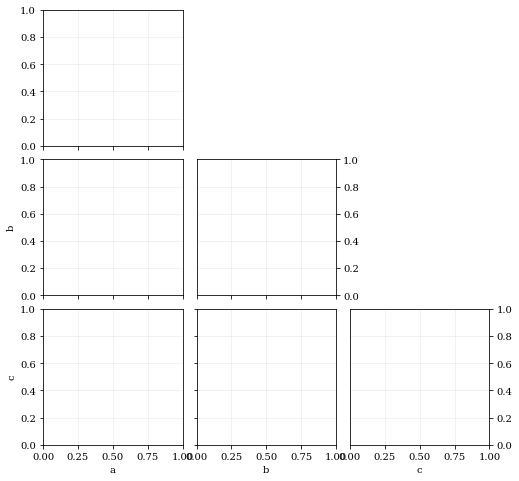

In [16]:
# Generate randomish data
data = kale.utils._random_data_3d_01()
# Initialize a corner plot with the given data, set axes labels
corner = kale.plot.Corner(data, labels=['a', 'b', 'c'], figsize=8)
# Plot with only histograms
corner.hist(color='blue')

# Corner / Pair Plot

In [ ]:
reload(kale.plot)
data = kale.utils._random_data_2d_03()

# data = _random_data_2d_03()

# Construct a KDE
kde = kale.KDE(data)  #, reflect=[[0, None], None, [None, 1]])

# kale.plot.corner(kde)

# Build a corner plot using the `kalepy` plotting submodule
# corner = kale.plot.Corner(kde)  #, figsize=[10, 10])

# Data points: red scatter and histograms
# corner.plot_data(color='red', scatter=dict(s=10, alpha=0.15))
# corner.plot(kde=False, data=True, color='red');

# KDE reconstructed density-distribution: blue contours and curves
# corner.plot(kde=True, data=False, color='blue');

corner = kale.plot.Corner(kde)
# corner.plot(kde=False, data=True, color='red');
corner.plot_data(color='red', dist2d=dict(contour=True, pad=True), scatter=True, sigmas=[0.5, 1, 2])

# axes = corner.axes
# xlim = None
# ylim = None
# for ii in range(2):
#     xlim = zmath.minmax(axes[ii, 0].get_xlim(), prev=xlim)
#     ylim = zmath.minmax(axes[1, ii].get_ylim(), prev=ylim)
    
# axes[1, 0].set(xlim=xlim, ylim=ylim)
# axes[0, 0].set(xlim=xlim)
# axes[1, 1].set(ylim=ylim)



In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

# kernel = 'parabola'
kernel = 'gaussian'
weights = np.square(data[-1, :])
weights /= weights.max()
print(kale.utils.stats_str(weights))
weights = None
kde = kale.KDE(data, kernel=kernel, weights=weights)

corner = kale.plot.Corner(kde, figsize=[10, 10], labels=labels)

corner.plot(rotate=False, kde_kwargs=dict(color='r'), data_kwargs=dict(color='b'))

nbshow()
fname = 'corner.png'
save_fig(corner.fig, fname)

# Compare Data to KDE

## 1D Distributions

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 8], ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
colors = ['k', 'r', 'b']

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)

yextr = None
for kk, ax_col in enumerate(axes.T):
    color = colors[kk]
    
    ax = ax_col[0]
    ax.set(xlabel=labels[kk])
    kale.plot.dist1d_kde(ax, kde, param=kk, color=color)

    ax = ax_col[1]
#     ax.set(xlabel=labels[jj], ylabel=labels[ii])
    kale.plot.dist1d_data(ax, data=data[kk], color=color)
    

    extr = [None, None]
    for ax in ax_col:
        for ii, get_func in enumerate([ax.get_xlim, ax.get_ylim]):
            extr[ii] = kale.utils.minmax(get_func(), prev=extr[ii])
        
    for ax in ax_col:
        for ii, set_func in enumerate([ax.set_xlim, ax.set_ylim]):
            set_func(extr[ii])

nbshow()
fname = 'compare-1d.png'
save_fig(fig, fname)

## 2D Distributions

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 8], ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
colors = ['k', 'r', 'b']

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)

for kk, ax_col in enumerate(axes.T):
    color = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    jj, ii = np.sort([jj, ii])

    ax = ax_col[0]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    kale.plot.dist2d_kde(ax, kde, params=[jj, ii], color=color)

    ax = ax_col[1]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    kale.plot.dist2d_data(ax, data=[data[jj], data[ii]], color=color)
    
    extr = [None, None]
    for ax in ax_col:
        for ii, get_func in enumerate([ax.get_xlim, ax.get_ylim]):
            extr[ii] = kale.utils.minmax(get_func(), prev=extr[ii])

    for ax in ax_col:
        for ii, set_func in enumerate([ax.set_xlim, ax.set_ylim]):
            set_func(extr[ii])
            
nbshow()
fname = 'compare-2d.png'
save_fig(fig, fname)

# Data

## Full Corner Plot

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

corner = kale.plot.Corner(data, figsize=[10, 10], labels=labels)

edges = None
scatter = True
# scatter = False
smap = dict(log=True)
hist1d = dict(joints=False)
hist2d = dict()
# hist2d = False
contour = dict(linewidths=2.0)
# contour = False

corner.plot_data(color='r', edges=edges, mask_dense=False, mask_sparse=False,
                 scatter=scatter, smap=smap, hist1d=hist1d, hist2d=hist2d, contour=contour)

nbshow()
fname = 'corner-test-data.png'
save_fig(corner.fig, fname)

## 1D Distributions

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

for kk, ax in enumerate(axes):
    ax.grid(True, alpha=0.2)
    col = colors[kk]
    ax.set(xlabel=labels[kk])  
    kale.plot.dist1d_data(ax, data=data[kk], color=col)

nbshow()
fname = 'corner-test-data-1d.png'
save_fig(fig, fname)

## 2D Distributions

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

for kk, ax in enumerate(axes):
    col = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    jj, ii = np.sort([jj, ii])
    td = [data[jj], data[ii]]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    
    kale.plot.dist2d_data(ax, data=td, color=col,
                            mask_dense=True, mask_sparse=True, hist2d=True, density=True)

nbshow()
fname = 'corner-test-data-2d.png'
save_fig(fig, fname)

# KDEs

## Full Corner Plot

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)
corner = kale.plot.Corner(kde, figsize=[10, 10], labels=labels)
corner.plot_kde()

nbshow()

## 1D Distributions

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

kde = kale.KDE(data)

for kk, ax in enumerate(axes):
    ax.grid(True, alpha=0.2)
    col = colors[kk]
    ax.set(xlabel=labels[kk]) 
    kale.plot.dist1d_kde(ax, kde, param=kk, color=col)

nbshow()
fname = 'corner-test-kde-1d.png'
save_fig(fig, fname)

## 2D Distributions

In [ ]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)

for kk, ax in enumerate(axes):
    col = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    params = np.sort([jj, ii])
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    
    kale.plot.dist2d_kde(ax, kde, params=params, color=col)
    
nbshow()
fname = 'corner-test-kde-2d.png'
save_fig(fig, fname)

# Other

## Weighted Data

In [ ]:
reload(kalepy)
reload(kalepy.kde)
reload(kalepy.plot)
reload(kalepy.utils)
kw = dict(lw=2.0, alpha=0.5)

xx = np.random.normal(size=1000)
yy = 100*np.fabs(xx)

ax = plt.gca()
ax.hist(xx, weights=yy, density=True, histtype='step', color='b', **kw)
# ax.hist(xx, density=True, histtype='step', color='b', ls='--', **kw)

kde = kale.KDE(xx, kernel='gaussian', weights=yy)
edges = kde.points
pdf = kde.pdf(edges)[1]
ax.plot(edges, pdf, **kw)
kale.plot.dist1d_kde(ax, kde, ls='--', contour=False, **kw)
kale.plot.dist1d_data(ax, data=xx, weights=yy, contour=False, color='r')

nbshow()
